## import package

In [1]:
from IPython.display import display
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.ml.linalg import Vectors, SparseVector, VectorUDT

In [2]:
import numpy as np
import scipy.sparse
import math
import datetime
import time
import itertools
import pandas as pd
%matplotlib inline

## load data

In [3]:
# train set, test set 불러오기
train = spark.read.format('csv').option("header", "true").load('gs://capstone-03/data/train_sample_df_3.csv')
test = spark.read.format('csv').option("header", "true").load('gs://capstone-03/data/test_sample_df_3.csv')

In [5]:
from pyspark.sql.functions import col
train = train.select(*(col(c).cast("string").alias(c) for c in train.columns))

In [6]:
test = test.select(*(col(c).cast("string").alias(c) for c in test.columns))

In [7]:
from pyspark.sql.functions import lit
train = train.withColumn("is_train", lit(1))
test = test.withColumn("is_train", lit(0))

In [12]:
# print((train.count(), len(train.columns)))
# print((test.count(), len(test.columns)))

(1032825, 31)
(272177, 31)


In [8]:
# train set, test set 합치기
union = train.union(test)

In [14]:
# print((union.count(), len(union.columns)))

(1305002, 31)


In [9]:
raw_df = union
raw_df.printSchema()

root
 |-- display_id: string (nullable = true)
 |-- ad_id: string (nullable = true)
 |-- label: string (nullable = true)
 |-- is_leak: string (nullable = true)
 |-- weekend: string (nullable = true)
 |-- view_publisher_id: string (nullable = true)
 |-- view_source_id: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- traffic_source: string (nullable = true)
 |-- country: string (nullable = true)
 |-- day_event: string (nullable = true)
 |-- campaign_id: string (nullable = true)
 |-- advertiser_id: string (nullable = true)
 |-- ad_category_id: string (nullable = true)
 |-- ad_topic_id: string (nullable = true)
 |-- view_category_id: string (nullable = true)
 |-- view_topic_id: string (nullable = true)
 |-- timestamp_event: string (nullable = true)
 |-- ad_source_id: string (nullable = true)
 |-- ad_publisher_id: string (nullable = true)
 |-- pop_ad_id: string (nullable = true)
 |-- pop_ad_doc_id: string (nullable = true)
 |-- pop_a

In [16]:
# pd.DataFrame(raw_df.take(5), columns=raw_df.columns).transpose()

,0,1,2,3,4
display_id,2790527,4189325,2806444,2783288,55830
ad_id,151311,151311,151311,151311,151311
label,0,1,0,0,0
is_leak,-1,-1,0,-1,-1
weekend,0,0,0,0,0
view_publisher_id,28,450,784,1089,784
view_source_id,353,7736,6698,U,6698
hour,3,1,3,3,6
platform,2,2,2,2,3
traffic_source,1,1,1,3,1


In [10]:
# 'day_event', 'timestamp_event' 제외 (시간 변수는 필요 없어서) 
raw_df = raw_df.select([c for c in raw_df.columns if c not in {'day_event', 'timestamp_event'}])

# 뒤에 outputCol로 'label'을 사용해서, 'label'이 중복되지 않도록, data의 'label' 컬럼명을 "ClickOrNot"로 바꿔준다
raw_df = raw_df.withColumnRenamed("label", "ClickOrNot")

# raw_df를 printSchema 해보기
raw_df.printSchema()
print((raw_df.count(), len(raw_df.columns))) # (1305002, 29)

root
 |-- display_id: string (nullable = true)
 |-- ad_id: string (nullable = true)
 |-- ClickOrNot: string (nullable = true)
 |-- is_leak: string (nullable = true)
 |-- weekend: string (nullable = true)
 |-- view_publisher_id: string (nullable = true)
 |-- view_source_id: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- traffic_source: string (nullable = true)
 |-- country: string (nullable = true)
 |-- campaign_id: string (nullable = true)
 |-- advertiser_id: string (nullable = true)
 |-- ad_category_id: string (nullable = true)
 |-- ad_topic_id: string (nullable = true)
 |-- view_category_id: string (nullable = true)
 |-- view_topic_id: string (nullable = true)
 |-- ad_source_id: string (nullable = true)
 |-- ad_publisher_id: string (nullable = true)
 |-- pop_ad_id: string (nullable = true)
 |-- pop_ad_doc_id: string (nullable = true)
 |-- pop_ad_publisher_id: string (nullable = true)
 |-- pop_advertiser_id: string (nullable =

## feature engineering - numeric

In [ ]:
# numeric_features 없음, 이 코드 건너뛰기
# numeric_features = [t[0] for t in df.dtypes if t[1] == 'int'] # numeric features 이름 저장
# df.select(numeric_features).describe().toPandas().transpose()

## feature engineering - categorical

In [11]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ['weekend', 'view_publisher_id', 'view_source_id', 'hour', 'platform', 'traffic_source', 'country', 'campaign_id', 'advertiser_id', 'ad_category_id', 'ad_topic_id', 'view_category_id', 'view_topic_id', 'ad_source_id', 'ad_publisher_id', 'pop_ad_id', 'pop_ad_doc_id', 'pop_ad_publisher_id', 'pop_advertiser_id', 'pop_campaign_id', 'pop_view_doc_ad_doc', 'pop_ad_source_id', 'pop_ad_topic_id', 'pop_ad_category_id']
# categoricalColumns : 24개
# 사용하지 않은 컬럼 : 5개 ('display_id', 'ad_id', 'ClickOrNot', 'is_leak', 'is_train')
stages = []

In [12]:
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

In [ ]:
# df.select('column1').distinct().count()

## feature engineering - label

In [13]:
label_stringIdx = StringIndexer(inputCol = 'ClickOrNot', outputCol = 'label')
stages += [label_stringIdx]

## feature engineering - assembler (categorical)

In [14]:
assemblerInputs = [c + "classVec" for c in categoricalColumns]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

## feature engineering - assembler (numeric)

In [ ]:
# numeric_features 없음, 이 코드 건너뛰기
# numericCols = []
# assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
# assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
# stages += [assembler]

## pipeline

In [15]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(raw_df)
transform_df = pipelineModel.transform(raw_df)
cols = raw_df.columns
selectedCols = ['label', 'features'] + cols
selected_df = transform_df.select(selectedCols)

In [16]:
selected_df.printSchema()
print((selected_df.count(), len(selected_df.columns))) # 29 -> 31  : new columns('label', 'features') are added

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- display_id: string (nullable = true)
 |-- ad_id: string (nullable = true)
 |-- ClickOrNot: string (nullable = true)
 |-- is_leak: string (nullable = true)
 |-- weekend: string (nullable = true)
 |-- view_publisher_id: string (nullable = true)
 |-- view_source_id: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- traffic_source: string (nullable = true)
 |-- country: string (nullable = true)
 |-- campaign_id: string (nullable = true)
 |-- advertiser_id: string (nullable = true)
 |-- ad_category_id: string (nullable = true)
 |-- ad_topic_id: string (nullable = true)
 |-- view_category_id: string (nullable = true)
 |-- view_topic_id: string (nullable = true)
 |-- ad_source_id: string (nullable = true)
 |-- ad_publisher_id: string (nullable = true)
 |-- pop_ad_id: string (nullable = true)
 |-- pop_ad_doc_id: string (nullable = true)
 |-- pop_ad_pub

In [24]:
# pd.DataFrame(selected_df.take(5), columns=selected_df.columns).transpose()

,0,1,2,3,4
label,0,1,0,0,0
features,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
display_id,2790527,4189325,2806444,2783288,55830
ad_id,151311,151311,151311,151311,151311
ClickOrNot,0,1,0,0,0
is_leak,-1,-1,0,-1,-1
weekend,0,0,0,0,0
view_publisher_id,28,450,784,1089,784
view_source_id,353,7736,6698,U,6698
hour,3,1,3,3,6


In [122]:
# print(type(selected_df))

pyspark.sql.dataframe.DataFrame

In [28]:
selected_df.take(1)

[Row(label=0.0, features=SparseVector(34867, {0: 1.0, 75: 1.0, 527: 1.0, 2790: 1.0, 2794: 1.0, 2795: 1.0, 2798: 1.0, 8589: 1.0, 26609: 1.0, 28191: 1.0, 28312: 1.0, 28547: 1.0, 28679: 1.0, 28963: 1.0, 34138: 1.0, 34832: 1.0, 34836: 1.0, 34839: 1.0, 34844: 1.0, 34850: 1.0, 34851: 1.0, 34857: 1.0, 34860: 1.0, 34864: 1.0}), display_id=u'2790527', ad_id=u'151311', ClickOrNot=u'0', is_leak=u'-1', weekend=u'0', view_publisher_id=u'28', view_source_id=u'353', hour=u'3', platform=u'2', traffic_source=u'1', country=u'U', campaign_id=u'16314', advertiser_id=u'2302', ad_category_id=u'1407', ad_topic_id=u'10', view_category_id=u'1708', view_topic_id=u'107', ad_source_id=u'368', ad_publisher_id=u'U', pop_ad_id=u'1', pop_ad_doc_id=u'1', pop_ad_publisher_id=u'U', pop_advertiser_id=u'1', pop_campaign_id=u'1', pop_view_doc_ad_doc=u'U', pop_ad_source_id=u'1', pop_ad_topic_id=u'1', pop_ad_category_id=u'1', is_train=1)]

In [17]:
# selected_pd = selected_df["features"].toPandas()

TypeError: 'Column' object is not callable

## train, valid split

In [18]:
train = selected_df.filter(selected_df.is_train==1)
test = selected_df.filter(selected_df.is_train==0)

In [19]:
train, valid = selected_df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Validation Dataset Count: " + str(valid.count()))

Training Dataset Count: 913072
Validation Dataset Count: 391889


## 1. logistic regression model

### 1.1 logistic regression - training

In [20]:
import datetime
start_time = time.time()

from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10) # x는 'features', y는 'label'
lrModel = lr.fit(train) # 로지스틱 회귀 모델 트레이닝 시키기

print("--- %s seconds ---" % (time.time() - start_time))

--- 44.0883798599 seconds ---


/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


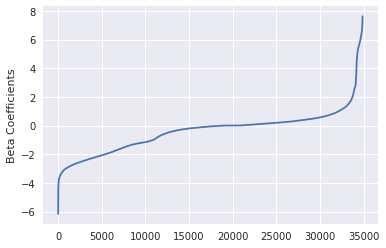

In [21]:
# coef
import matplotlib.pyplot as plt
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()
# 회귀 계수가 34867개, 값은 -6.2~7.6 사이에 분포

In [22]:
# print(len(beta))
# print(min(beta))
# print(max(beta))

34867
-6.168102223527297
7.6339803355328515


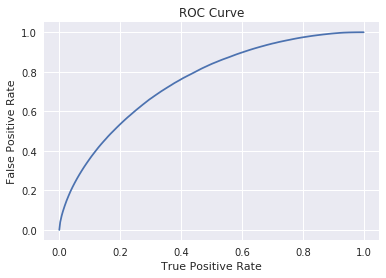

In [23]:
# ROC curve
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

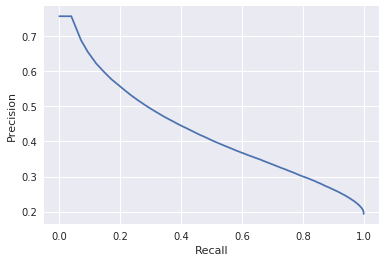

Training set areaUnderROC: 0.752746424309


In [24]:
# precision and recall
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

### 1.2 logistic regression - validation

In [25]:
# prediction
lrPredictions = lrModel.transform(valid)
lrPredictions.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- display_id: string (nullable = true)
 |-- ad_id: string (nullable = true)
 |-- ClickOrNot: string (nullable = true)
 |-- is_leak: string (nullable = true)
 |-- weekend: string (nullable = true)
 |-- view_publisher_id: string (nullable = true)
 |-- view_source_id: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- traffic_source: string (nullable = true)
 |-- country: string (nullable = true)
 |-- campaign_id: string (nullable = true)
 |-- advertiser_id: string (nullable = true)
 |-- ad_category_id: string (nullable = true)
 |-- ad_topic_id: string (nullable = true)
 |-- view_category_id: string (nullable = true)
 |-- view_topic_id: string (nullable = true)
 |-- ad_source_id: string (nullable = true)
 |-- ad_publisher_id: string (nullable = true)
 |-- pop_ad_id: string (nullable = true)
 |-- pop_ad_doc_id: string (nullable = true)
 |-- pop_ad_pub

In [22]:
# lrPredictions.select('display_id', 'ad_id', 'prediction', 'probability').show(10)

+----------+------+----------+--------------------+
|display_id| ad_id|prediction|         probability|
+----------+------+----------+--------------------+
|   1081731|152055|       0.0|[0.76129631585395...|
|   3913279|152057|       0.0|[0.76203140932029...|
|   7458692| 99212|       0.0|[0.75418243465143...|
|  11560018|134138|       0.0|[0.77065209610854...|
|   4170347|  9654|       0.0|[0.89919481341470...|
|   1411158|154873|       0.0|[0.87229286437417...|
|   8787510| 34906|       0.0|[0.98808825086495...|
|   7706137|195697|       0.0|[0.88627140062789...|
|  12958619|223540|       0.0|[0.94814998152488...|
|  12958619|243487|       0.0|[0.84796579062123...|
+----------+------+----------+--------------------+
only showing top 10 rows



In [26]:
# evaluation
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Validation Area Under ROC', evaluator.evaluate(lrPredictions))

('Validation Area Under ROC', 0.7109512437767408)


### 1.3 logistic regression - testing

In [27]:
# prediction
lrPredictions = lrModel.transform(test)
lrPredictions.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- display_id: string (nullable = true)
 |-- ad_id: string (nullable = true)
 |-- ClickOrNot: string (nullable = true)
 |-- is_leak: string (nullable = true)
 |-- weekend: string (nullable = true)
 |-- view_publisher_id: string (nullable = true)
 |-- view_source_id: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- traffic_source: string (nullable = true)
 |-- country: string (nullable = true)
 |-- campaign_id: string (nullable = true)
 |-- advertiser_id: string (nullable = true)
 |-- ad_category_id: string (nullable = true)
 |-- ad_topic_id: string (nullable = true)
 |-- view_category_id: string (nullable = true)
 |-- view_topic_id: string (nullable = true)
 |-- ad_source_id: string (nullable = true)
 |-- ad_publisher_id: string (nullable = true)
 |-- pop_ad_id: string (nullable = true)
 |-- pop_ad_doc_id: string (nullable = true)
 |-- pop_ad_pub

In [25]:
lrPredictions.select('display_id', 'ad_id', 'prediction', 'probability').show(10)

+----------+------+----------+--------------------+
|display_id| ad_id|prediction|         probability|
+----------+------+----------+--------------------+
|  15545104|  1419|       0.0|[0.83584025903596...|
|  15523904|   784|       0.0|[0.98907946132185...|
|  16731814|   949|       0.0|[0.99449288156133...|
|  13517470|492732|       0.0|[0.75908094180666...|
|  14303795|492733|       0.0|[0.69496098289604...|
|  13473156|492732|       0.0|[0.62109731036974...|
|  14323230|492733|       0.0|[0.83317909395105...|
|  13529851|  2425|       0.0|[0.92671064982825...|
|  16652787|492733|       0.0|[0.72769099850367...|
|  16745936|492733|       0.0|[0.77593326529769...|
+----------+------+----------+--------------------+
only showing top 10 rows



In [28]:
# evaluation
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(lrPredictions))

('Test Area Under ROC', 0.7382635207381258)


### 1.4 logistic regression - map@12

In [29]:
# display_id, ad_id, probability를 셀렉해 logistic_final_df에 저장
logistic_final_df = lrPredictions.select('display_id', 'ad_id', 'probability')
# spark dataframe을 pandas dataframe으로 변환
logistic_final_pd = logistic_final_df.toPandas()

In [30]:
# probability는 [0일 확률, 1일 확률]로 되어 있다 -> 1일 확률만 뽑아 'clickprob' 열에 저장하자

# 일단 copy해서 'clickprob' 열 생성해놓자
logistic_final_pd['clickprob'] = logistic_final_pd.probability 

# for문 돌려서 1일 확률만 뽑아 'clickprob' 열에 저장하자
for i in range(len(logistic_final_pd)): # for문
    logistic_final_pd.clickprob[i] = logistic_final_pd.probability[i][1]

In [31]:
# 'display_id', 'ad_id', 'clickprob'만 저장해야지
logistic_final_pd = logistic_final_pd[['display_id', 'ad_id', 'clickprob']]

# csv 파일로 bucket에 저장하자
from io import BytesIO
logistic_final_pd.to_csv('logistic.csv', index=False)
!gsutil cp 'logistic.csv' 'gs://capstone-03/output/logistic.csv'



Updates are available for some Cloud SDK components.  To install them,
please run:
  $ gcloud components update

Copying file://logistic.csv [Content-Type=text/csv]...
/ [1 files][  9.2 MiB/  9.2 MiB]                                                
Operation completed over 1 objects/9.2 MiB.                                      


In [33]:
test_label = test.select('display_id', 'ad_id', 'label').toPandas()
pd_merge = pd.merge(test_label, logistic_final_pd, how='left', left_on=['display_id', 'ad_id'], right_on=['display_id', 'ad_id'])

In [34]:
pd_merge.sort_values(['display_id', 'clickprob'], inplace=True, ascending=[True, False])

In [35]:
from ml_metrics import mapk

Y_ads = pd_merge[pd_merge.label == 1].ad_id.values.reshape(-1,1) 
P_ads = pd_merge.groupby(by='display_id', sort=False).ad_id.apply( lambda x: x.values ).values

In [36]:
# mapk 함수
score = mapk(Y_ads, P_ads, 12)
print("MAP: %.12f" % score)

MAP: 0.652949544010


## 2. random forest

### 2.1 random forest - training & validation

In [37]:
import datetime
start_time = time.time()

from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
rfPredictions = rfModel.transform(valid)
%time rfPredictions.select('display_id', 'ad_id', 'prediction', 'probability').show(10)

print("--- %s seconds ---" % (time.time() - start_time))

+----------+------+----------+--------------------+
|display_id| ad_id|prediction|         probability|
+----------+------+----------+--------------------+
|   1081731|152055|       0.0|[0.80578987119454...|
|   3913279|152057|       0.0|[0.80578987119454...|
|   7458692| 99212|       0.0|[0.80578987119454...|
|  11560018|134138|       0.0|[0.80578987119454...|
|   4170347|  9654|       0.0|[0.80578987119454...|
|   1411158|154873|       0.0|[0.80578987119454...|
|   8787510| 34906|       0.0|[0.83003622572713...|
|   7706137|195697|       0.0|[0.80578987119454...|
|  12958619|223540|       0.0|[0.81944155202292...|
|  12958619|243487|       0.0|[0.80578987119454...|
+----------+------+----------+--------------------+
only showing top 10 rows

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.99 s
--- 335.786329985 seconds ---


In [38]:
print(rfModel.featureImportances)
# spark에는 random forest 변수 중요도 시각화 기능이 없어요, 대신 아래와 같이 리스트를 반환
# feature 개수 : 34867
# 첫번째 리스트 : 변수 index
# 두번째 리스트 : 해당 변수 index의 weight
# 참고 -> https://stackoverflow.com/questions/37878519/understanding-spark-randomforest-featureimportances-results

(34867,[2,4,9,13,14,16,23,25,27,30,63,64,81,86,97,105,131,139,155,164,175,181,188,276,303,317,362,461,463,471,482,483,487,489,495,511,521,522,536,553,575,591,594,601,641,672,677,694,709,755,788,793,806,840,897,909,976,1064,1086,1137,1403,1480,1955,2020,2705,2788,2790,2791,2792,2794,2795,2802,2804,2811,2812,2843,2854,2862,2872,2903,2915,2935,2973,2975,3063,3106,3111,3149,3175,3247,3301,3302,3380,3418,3556,3637,4028,4111,4762,4789,5390,5667,5672,7661,7981,9008,9867,13617,15288,17247,24684,24685,24687,24688,24691,24692,24701,24751,24832,24866,24872,24887,24898,24906,24924,24929,24950,25145,25149,25154,25694,28151,28152,28161,28210,28222,28248,28251,28255,28260,28262,28264,28289,28293,28360,28371,28400,28421,28545,28546,28547,28548,28556,28559,28560,28561,28563,28564,28567,28568,28570,28577,28585,28587,28591,28600,28608,28609,28634,28635,28638,28641,28643,28652,28653,28654,28658,28665,28666,28668,28671,28673,28679,28681,28690,28719,28720,28725,28727,28744,28753,28758,28761,28770,28774,2878

In [39]:
evaluator = BinaryClassificationEvaluator()
print("Validation Area Under ROC: " + str(evaluator.evaluate(rfPredictions, {evaluator.metricName: "areaUnderROC"})))

Validation Area Under ROC: 0.604478429964


### 2.2 random forest - testing

In [40]:
rfPredictions = rfModel.transform(test)
%time rfPredictions.select('display_id', 'ad_id', 'prediction', 'probability').show(10)

+----------+------+----------+--------------------+
|display_id| ad_id|prediction|         probability|
+----------+------+----------+--------------------+
|  15545104|  1419|       0.0|[0.80578987119454...|
|  15523904|   784|       0.0|[0.80578987119454...|
|  16731814|   949|       0.0|[0.80374513700798...|
|  13517470|492732|       0.0|[0.80458142720854...|
|  14303795|492733|       0.0|[0.80253669302199...|
|  13473156|492732|       0.0|[0.80458142720854...|
|  14323230|492733|       0.0|[0.80766553313562...|
|  13529851|  2425|       0.0|[0.80578987119454...|
|  16652787|492733|       0.0|[0.80374513700798...|
|  16745936|492733|       0.0|[0.80374513700798...|
+----------+------+----------+--------------------+
only showing top 10 rows

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 9.35 s


In [41]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(rfPredictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.600539369914


### 2.3 random forest - map@12

In [42]:
# display_id, ad_id, probability를 셀렉해 logistic_final_df에 저장
ranfo_final_df = rfPredictions.select('display_id', 'ad_id', 'probability')
# spark dataframe을 pandas dataframe으로 변환
ranfo_final_pd = ranfo_final_df.toPandas()

In [43]:
# probability는 [0일 확률, 1일 확률]로 되어 있다 -> 1일 확률만 뽑아 'clickprob' 열에 저장하자

# 일단 copy해서 'clickprob' 열 생성해놓자
ranfo_final_pd['clickprob'] = ranfo_final_pd.probability 

# for문 돌려서 1일 확률만 뽑아 'clickprob' 열에 저장하자
for i in range(len(ranfo_final_pd)): # for문
    ranfo_final_pd.clickprob[i] = ranfo_final_pd.probability[i][1]

In [44]:
# 'display_id', 'ad_id', 'clickprob'만 저장해야지
ranfo_final_pd = ranfo_final_pd[['display_id', 'ad_id', 'clickprob']]

# csv 파일로 bucket에 저장하자
from io import BytesIO
ranfo_final_pd.to_csv('ranfo.csv', index=False)
!gsutil cp 'ranfo.csv' 'gs://capstone-03/output/ranfo.csv'

Copying file://ranfo.csv [Content-Type=text/csv]...
/ [1 files][  9.2 MiB/  9.2 MiB]                                                
Operation completed over 1 objects/9.2 MiB.                                      


In [45]:
test_label = test.select('display_id', 'ad_id', 'label').toPandas()
pd_merge = pd.merge(test_label, ranfo_final_pd, how='left', left_on=['display_id', 'ad_id'], right_on=['display_id', 'ad_id'])

In [46]:
pd_merge.sort_values(['display_id', 'clickprob'], inplace=True, ascending=[True, False] )

In [47]:
from ml_metrics import mapk

Y_ads = pd_merge[pd_merge.label == 1].ad_id.values.reshape(-1,1) 
P_ads = pd_merge.groupby(by='display_id', sort=False).ad_id.apply( lambda x: x.values ).values

In [48]:
# mapk 함수
score = mapk(Y_ads, P_ads, 12)
print("MAP: %.12f" % score)

MAP: 0.521161300537


## 3. gradient-boosted tree

### 3.1 gradient-boosted tree - training & validation

In [62]:
import datetime
start_time = time.time()

from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
gbtPredictions = gbtModel.transform(valid)
%time gbtPredictions.select('display_id', 'ad_id', 'prediction', 'probability').show(10)

print("--- %s seconds ---" % (time.time() - start_time))

+----------+------+----------+--------------------+
|display_id| ad_id|prediction|         probability|
+----------+------+----------+--------------------+
|   7555324|  3314|       0.0|[0.78516346849081...|
|  12910866|  3314|       0.0|[0.78516346849081...|
|  11547867|130875|       0.0|[0.80047597957764...|
|  10120858| 70534|       0.0|[0.80047597957764...|
|   3845616|404318|       0.0|[0.80047597957764...|
|   3808532| 99212|       0.0|[0.80047597957764...|
|  11592005|211009|       0.0|[0.80047597957764...|
|    100983| 70944|       0.0|[0.80047597957764...|
|  11560018|134138|       0.0|[0.80047597957764...|
|   7706137|223483|       0.0|[0.80047597957764...|
+----------+------+----------+--------------------+
only showing top 10 rows

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 6.83 s
--- 5856.39026403 seconds ---


In [ ]:
evaluator = BinaryClassificationEvaluator()
print("Validation Area Under ROC: " + str(evaluator.evaluate(gbtPredictions, {evaluator.metricName: "areaUnderROC"})))

### 3.2 gradient-boosted tree - testing

In [34]:
gbtPredictions = gbtModel.transform(test)
%time gbtPredictions.select('display_id', 'ad_id', 'prediction', 'probability').show(10)

+----------+------+----------+--------------------+
|display_id| ad_id|prediction|         probability|
+----------+------+----------+--------------------+
|  15545104|  1419|       0.0|[0.80062090727890...|
|  15523904|   784|       0.0|[0.80062090727890...|
|  16731814|   949|       0.0|[0.77492917104812...|
|  13517470|492732|       0.0|[0.80062090727890...|
|  14303795|492733|       0.0|[0.77492917104812...|
|  13473156|492732|       0.0|[0.80062090727890...|
|  14323230|492733|       0.0|[0.77492917104812...|
|  13529851|  2425|       0.0|[0.80062090727890...|
|  16652787|492733|       0.0|[0.77492917104812...|
|  16745936|492733|       0.0|[0.77492917104812...|
+----------+------+----------+--------------------+
only showing top 10 rows

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 11.2 s


In [ ]:
# display_id, ad_id, probability를 셀렉해 gbt_final_df에 저장
gbt_final_df = gbtPredictions.select('display_id', 'ad_id', 'probability')
# spark dataframe을 pandas dataframe으로 변환
gbt_final_pd = gbt_final_df.toPandas()

In [ ]:
# probability는 [0일 확률, 1일 확률]로 되어 있다 -> 1일 확률만 뽑아 'clickprob' 열에 저장하자

# 일단 copy해서 'clickprob' 열 생성해놓자
gbt_final_pd['clickprob'] = gbt_final_pd.probability 

# for문 돌려서 1일 확률만 뽑아 'clickprob' 열에 저장하자
for i in range(len(gbt_final_pd)): # for문
    gbt_final_pd.clickprob[i] = gbt_final_pd.probability[i][1]

In [ ]:
# 'display_id', 'ad_id', 'clickprob'만 저장해야지
gbt_final_pd = gbt_final_pd[['display_id', 'ad_id', 'clickprob']]

# csv 파일로 bucket에 저장하자
from io import BytesIO
gbt_final_pd.to_csv('gbt.csv', index=False)
!gsutil cp 'gbt.csv' 'gs://capstone-03/output/gbt.csv'

In [ ]:
test_label_pd = test.select('display_id', 'ad_id', 'label').toPandas()
pd_merge = pd.merge(test_label_pd, gbt_final_pd, how='left', left_on=['display_id', 'ad_id'], right_on=['display_id', 'ad_id'])

In [ ]:
pd_merge.sort_values(['display_id', 'clickprob'], inplace=True, ascending=[True, False] )

In [ ]:
from ml_metrics import mapk

Y_ads = pd_merge[pd_merge.label == 1].ad_id.values.reshape(-1,1) 
P_ads = pd_merge.groupby(by='display_id', sort=False).ad_id.apply( lambda x: x.values ).values

In [ ]:
# mapk 함수
score = mapk(Y_ads, P_ads, 12)
print("MAP: %.12f" % score)

#  dd

In [50]:
import datetime
start_time = time.time()

from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10, maxDepth=4)
gbtModel = gbt.fit(train)
gbtPredictions = gbtModel.transform(valid)
%time gbtPredictions.select('display_id', 'ad_id', 'prediction', 'probability').show(10)

print("--- %s seconds ---" % (time.time() - start_time)) # 1시간 36분

+----------+------+----------+--------------------+
|display_id| ad_id|prediction|         probability|
+----------+------+----------+--------------------+
|   7555324|  3314|       0.0|[0.77977612265712...|
|  12910866|  3314|       0.0|[0.77977612265712...|
|  11547867|130875|       0.0|[0.79731181072936...|
|  10120858| 70534|       0.0|[0.79731181072936...|
|   3786244| 99212|       0.0|[0.79731181072936...|
|  10491226|211009|       0.0|[0.79731181072936...|
|   7555324|109812|       0.0|[0.79731181072936...|
|   7706137|223483|       0.0|[0.79731181072936...|
|   4170347|  9654|       0.0|[0.79731181072936...|
|   9108355|  9654|       0.0|[0.79731181072936...|
+----------+------+----------+--------------------+
only showing top 10 rows

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 4.74 s
--- 3423.49501991 seconds ---


In [51]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print("Validation Area Under ROC: " + str(evaluator.evaluate(gbtPredictions, {evaluator.metricName: "areaUnderROC"})))

Validation Area Under ROC: 0.614694241305


In [52]:
gbtPredictions = gbtModel.transform(test)
%time gbtPredictions.select('display_id', 'ad_id', 'prediction', 'probability').show(10)

+----------+------+----------+--------------------+
|display_id| ad_id|prediction|         probability|
+----------+------+----------+--------------------+
|  15545104|  1419|       0.0|[0.79731181072936...|
|  15523904|   784|       0.0|[0.79731181072936...|
|  16731814|   949|       0.0|[0.78186976010320...|
|  13517470|492732|       0.0|[0.79731181072936...|
|  14303795|492733|       0.0|[0.78186976010320...|
|  13473156|492732|       0.0|[0.79731181072936...|
|  14323230|492733|       0.0|[0.78186976010320...|
|  13529851|  2425|       0.0|[0.79731181072936...|
|  16652787|492733|       0.0|[0.78186976010320...|
|  16745936|492733|       0.0|[0.78186976010320...|
+----------+------+----------+--------------------+
only showing top 10 rows

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 17.1 s


In [53]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(gbtPredictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.606938007376


### 1.3 gbt - map@12

In [54]:
# display_id, ad_id, probability를 셀렉해 gbt_final_df에 저장
gbt_final_df = gbtPredictions.select('display_id', 'ad_id', 'probability')
# spark dataframe을 pandas dataframe으로 변환
gbt_final_pd = gbt_final_df.toPandas()

In [55]:
# probability는 [0일 확률, 1일 확률]로 되어 있다 -> 1일 확률만 뽑아 'clickprob' 열에 저장하자

# 일단 copy해서 'clickprob' 열 생성해놓자
gbt_final_pd['clickprob'] = gbt_final_pd.probability 

# for문 돌려서 1일 확률만 뽑아 'clickprob' 열에 저장하자
for i in range(len(gbt_final_pd)): # for문
    gbt_final_pd.clickprob[i] = gbt_final_pd.probability[i][1]

In [56]:
# clickprob 열이 잘 생성되었다
gbt_final_pd.head(5)

,display_id,ad_id,probability,clickprob
0,15545104,1419,"[0.7973118107293689, 0.20268818927063115]",0.202688
1,15523904,784,"[0.7973118107293689, 0.20268818927063115]",0.202688
2,16731814,949,"[0.7818697601032099, 0.21813023989679015]",0.21813
3,13517470,492732,"[0.7973118107293689, 0.20268818927063115]",0.202688
4,14303795,492733,"[0.7818697601032099, 0.21813023989679015]",0.21813


In [57]:
# 'display_id', 'ad_id', 'clickprob'만 저장해야지
gbt_final_pd = gbt_final_pd[['display_id', 'ad_id', 'clickprob']]

# csv 파일로 bucket에 저장하자
from io import BytesIO
gbt_final_pd.to_csv('gbt.csv', index=False)
!gsutil cp 'gbt.csv' 'gs://capstone-03/output/gbt.csv'

Copying file://gbt.csv [Content-Type=text/csv]...
/ [1 files][  9.3 MiB/  9.3 MiB]                                                
Operation completed over 1 objects/9.3 MiB.                                      


In [58]:
test_label_pd = test.select('display_id', 'ad_id', 'label').toPandas()
pd_merge = pd.merge(test_label_pd, gbt_final_pd, how='left', left_on=['display_id', 'ad_id'], right_on=['display_id', 'ad_id'])

In [59]:
pd_merge.sort_values(['display_id', 'clickprob'], inplace=True, ascending=[True, False] )

In [60]:
from ml_metrics import mapk

Y_ads = pd_merge[pd_merge.label == 1].ad_id.values.reshape(-1,1) 
P_ads = pd_merge.groupby(by='display_id', sort=False).ad_id.apply( lambda x: x.values ).values

In [61]:
# mapk 함수
score = mapk(Y_ads, P_ads, 12)
print("MAP: %.12f" % score)

MAP: 0.536998706295
